In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Franck P. Vidal (Bangor University, UK)

# ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1) a data reader for CIL
 
This demo shows the result of the integration between gVirtualXray (gVXR) and the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/) that we developed during the *CIL Training and Bring Your Own Data User Hackathon* at Cambridge University. A cone-beam computed-tomography (CBCT) acquisition with Poisson noise is simulated with [gVXR](https://sourceforge.net/projects/gvirtualxray). The data is reconstructed with [CIL](https://github.com/TomographicImaging/CIL).

Author: Franck Vidal

Version: 1.2, 6 Nov 2023

# Aims of this session

1. Simulate a CBCT scan acquisition using gVXR;
2. Add Poisson noise corresponding to a given number of photons per pixel; and
3. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/).


In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filtration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator. 15,000 photons per pixels are used. 600 projections of 512x512 pixels are taken.

![Main parameters of the simulation](https://github.com/effepivi/CIL-User-Showcase/blob/gVXR2CIL/gVXR2CIL/pediatric-setup.png?raw=1)



# Main steps

1. Download the phantom data. Anthropomorphic data is used. It corresponds to a 5-year old boy. 

2. Extract surface meshes from the voxelied phantom.

3. Simulate an X-ray projection of a Welsh dragon made of quartz

![Simulation of an X-ray projection of a Welsh dragon made of quartz](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/visualisation.png)

4. Select the number of incident photons per pixel

5. Add the corresponding amount of Photonic noise 

![X-ray projection with Poisson noise](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/noisy-projection.png)

6. Simulate a CT scan

![Scanning eometry](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/CT-geometry.png)

7. Create the flat-field images with the corresponding amount of Photonic noise

![Average flat-field image with Poisson noise](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/average-flat-field.png)

8. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/)

![Visualisation of the reconstructed 3D volume](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/plotCT.png)

In [2]:
%matplotlib inline

The working directory is not necessary the path of the Notebook on my Mac. 
Use either:

```python
import pathlib
root_path = str(pathlib.Path().resolve())
```

or 

```python
root_path = str(globals()['_dh'][0])
```

to locate the path of the notebbok. This is useful to save output files.

In [3]:
root_path = str(globals()['_dh'][0])

# Create directories

This step is needed to store some files.

In [4]:
import os

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(os.path.abspath(directory)):

        # Create the directory
        os.mkdir(os.path.abspath(directory))

createDirectory(root_path + "/input_data")
createDirectory(root_path + "/input_data/meshes")
createDirectory(root_path + "/output")

# Import packages

In [5]:
import glob
import zipfile

import pandas as pd

from IPython.display import display
from IPython.display import Image

import matplotlib.pyplot as plt # Plotting
import numpy as np

from tifffile import imread, imwrite

from IPython.display import display
from IPython.display import Image

import SimpleITK as sitk

import matplotlib # To plot images

font = {'family' : 'serif',
         'size'   : 10
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

from tqdm.contrib import tzip


from ipywidgets import interact
import ipywidgets as widgets

import base64

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot
from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales
# gvxr.useLogFile()

from sitk2vtk import *
from reconstruct import *

if has_cil:
    from gvxrPython3.JSON2gVXRDataReader import *
    from cil.utilities.display import show_geometry
    from cil.utilities.jupyter import islicer

Mon Nov  6 16:34:55 2023 (WW) Spekpy is not installed, try Xpecgen instead.
Mon Nov  6 16:34:55 2023 (WW) Xpecgen is not installed either.


spekpy is not install, you won't be able to load a beam spectrum using spekpy
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.7 (2023-11-06T13:48:17) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.7 (2023-11-06T13:48:16) [Compiler: GNU g++] on Linux
CIL detected
Tigre detected


## Initialise GVXR using our JSON file

In [6]:
json_fname = root_path + "/Noise-CBCT.json"

# MS Windows
if os.name == "nt":
    json2gvxr.initGVXR(json_fname, renderer="EGL")
# MacOS
elif str(os.uname()).find("Darwin") >= 0:
    json2gvxr.initGVXR(json_fname, renderer="OPENGL")
# GNU/Linux
else:
    json2gvxr.initGVXR(json_fname, renderer="EGL")

Create an OpenGL context: 800x450


Mon Nov  6 16:34:56 2023 ---- Create window (ID: -1)
Mon Nov  6 16:34:56 2023 ---- Query the number of EGL devices
Mon Nov  6 16:34:56 2023 ---- Success
Mon Nov  6 16:34:56 2023 ---- Detected 3 EGL devices.
Mon Nov  6 16:34:56 2023 ---- Print the details here of every EGL device.
Mon Nov  6 16:34:56 2023 ---- Success
Mon Nov  6 16:34:56 2023 ---- Device 1/3:
Mon Nov  6 16:34:56 2023 ---- 	Device Extensions: EGL_NV_device_cuda EGL_EXT_device_drm EGL_EXT_device_drm_render_node EGL_EXT_device_query_name EGL_EXT_device_persistent_id
Mon Nov  6 16:34:56 2023 ---- Device 2/3:
Mon Nov  6 16:34:56 2023 ---- 	Device Extensions: EGL_EXT_device_drm EGL_EXT_device_drm_render_node
Mon Nov  6 16:34:56 2023 ---- Device 3/3:
Mon Nov  6 16:34:56 2023 ---- 	Device Extensions: EGL_MESA_device_software EGL_EXT_device_drm_render_node
Mon Nov  6 16:34:56 2023 ---- Initialise EGL
Mon Nov  6 16:34:56 2023 ---- EGL client extensions:
Mon Nov  6 16:34:56 2023 ---- EGL_EXT_platform_base EGL_EXT_device_base EGL_E

## Create the output directory

In [7]:
raw_projection_output_dir = os.path.abspath(json2gvxr.getFilePath(json2gvxr.params["Scan"]["OutFolder"]))
print("The raw projections were saved in", raw_projection_output_dir)
createDirectory(raw_projection_output_dir + "/..")
createDirectory(raw_projection_output_dir)

The raw projections were saved in /home/fpvidal/PROGRAMMING/GitHub/CIL-User-Showcase/gVXR2CIL/raw_projections


## Load our detector

In [8]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, -150.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [128, 128]
	Detector number of pixels: [128, 128]
	Energy response: energyResponseDetector.txt in MeV
	Pixel spacing: [3.90625, 3.90625, 'mm']


In [9]:
number_of_rows = json2gvxr.params["Detector"]["NumberOfPixels"][1]
number_of_cols = json2gvxr.params["Detector"]["NumberOfPixels"][0]

## Load our source properties

In [10]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 1000.0, 0.0, 'mm']
	Source shape: PointSource


In [11]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

Mon Nov  6 16:34:57 2023 ---- Initialise the renderer


Text(0.5, 1.0, 'Corresponding spectra')

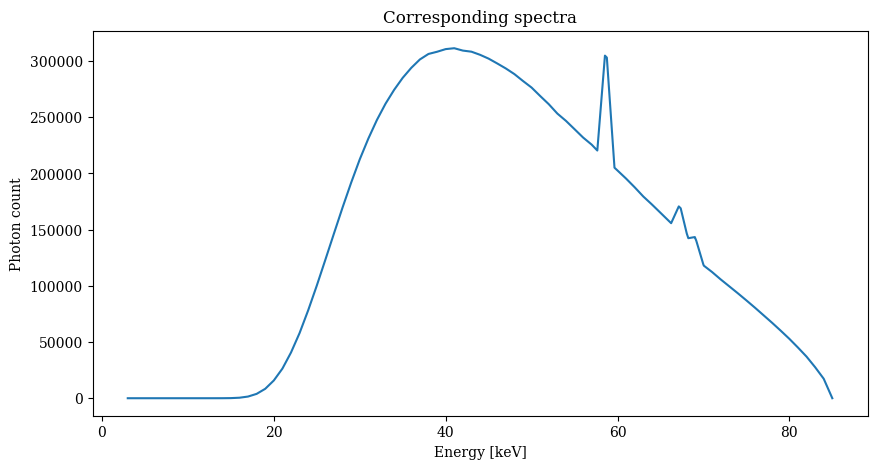

In [12]:
plt.figure(figsize=(10,5))
plt.plot(energy_set, bin_sets)
plt.xlabel("Energy [" + unit_of_energy + "]")
plt.ylabel("Photon count")
plt.title("Corresponding spectra")

## Create the surface meshes

Download and extract the ZIP file.

In [13]:
if not os.path.exists("input_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1",
                               root_path + "/input_data/Pediatric phantom.zip")

    with zipfile.ZipFile(root_path + "/input_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall(root_path + "/input_data")

Load the phantom

In [14]:
phantom = sitk.ReadImage(root_path + "/input_data/Pediatric phantom/Pediatric_model.mhd")

Load the labels

In [15]:
df = pd.read_csv(root_path + "/labels.dat")

Process every structure of the phantom

In [16]:
meshes = []

for threshold, organ in tzip(df["Label"], df["Organs"],
                         desc="Processing anatomy"):

    # Ignore air
    if organ != "Air":

        mesh_fname = root_path + "/input_data/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):

            # Threshold the phantom
            binary_image = (phantom == threshold)

            # Smooth the binary segmentation
            smoothed_binary_image = sitk.AntiAliasBinary(binary_image)

            # Create a VTK image
            vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            vtk_mesh = extractSurface(vtkimg, 0)
            writeSTL(vtk_mesh, mesh_fname)

Processing anatomy:   0%|          | 0/24 [00:00<?, ?it/s]

In [17]:
del phantom

## Load our samples

In [18]:
json2gvxr.initSamples(verbose=0)

Mon Nov  6 16:34:58 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/CIL-User-Showcase/gVXR2CIL/input_data/meshes/Muscle.stl	nb_faces:	1756726	nb_vertices:	5270178	bounding_box (in cm):	(-17.9687, -10.8887, -30.9017)	(16.6016, 11.1799, 28.6986)
Mon Nov  6 16:34:58 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/CIL-User-Showcase/gVXR2CIL/input_data/meshes/Bone.stl	nb_faces:	541826	nb_vertices:	1625478	bounding_box (in cm):	(-16.7969, -23.6577, -30.9017)	(15.2152, 9.88865, 16.3501)
Mon Nov  6 16:34:58 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/CIL-User-Showcase/gVXR2CIL/input_data/meshes/Stomach-Interior.stl	nb_faces:	9452	nb_vertices:	28356	bounding_box (in cm):	(-1.34334, -2.38867, -17.0041)	(4.16143, 3.05231, -8.50205)
Mon Nov  6 16:34:58 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/CIL-User-Showcase/gVXR2CIL/input_data/meshes/Cartilage.stl	nb_faces:	163322	nb_vertices:	489966	bounding_box (in cm):	(-16.7615, -4.32288, -30.9017)	(15.5041, 8.717, 16.6771

In [19]:
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")
centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Bounding box: [-172.85147094726562, -174.18807983398438, -300.0243225097656] [172.85147094726562, 174.18809509277344, 300.0243225097656]
Bounding box centre: [0.0, 7.62939453125e-06, 0.0]


## Let's get an x-ray image

We create an X-ray image `projection_in_MeV`.
By default the image is expressed in MeV.
We convert it to keV for display as follows: `projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")`.

In [20]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")

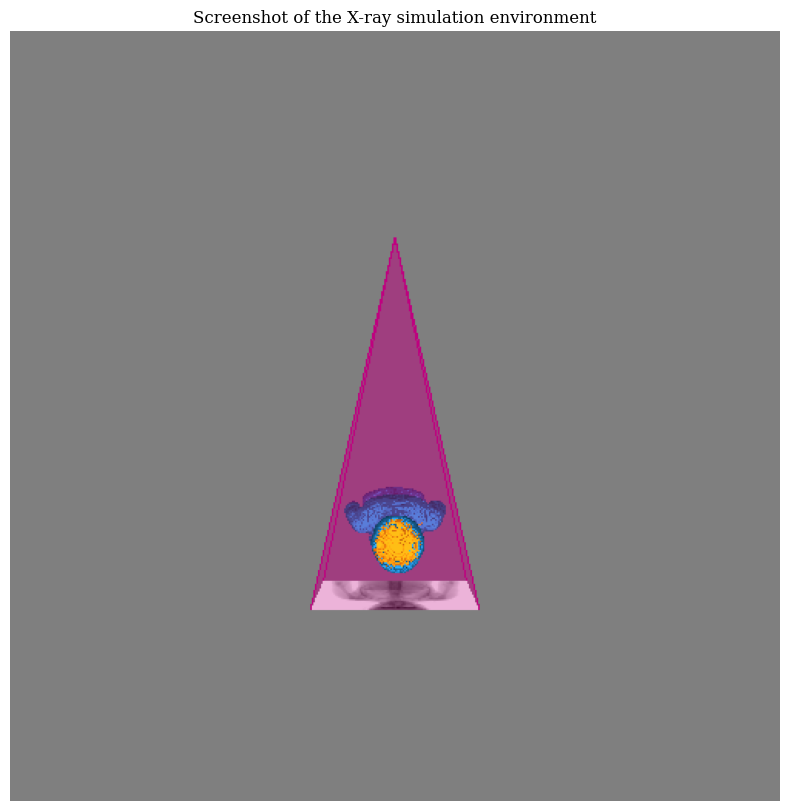

In [21]:
gvxr.setWindowSize(500, 500) # Fix for MacOS
gvxr.displayScene()
plotScreenshot()

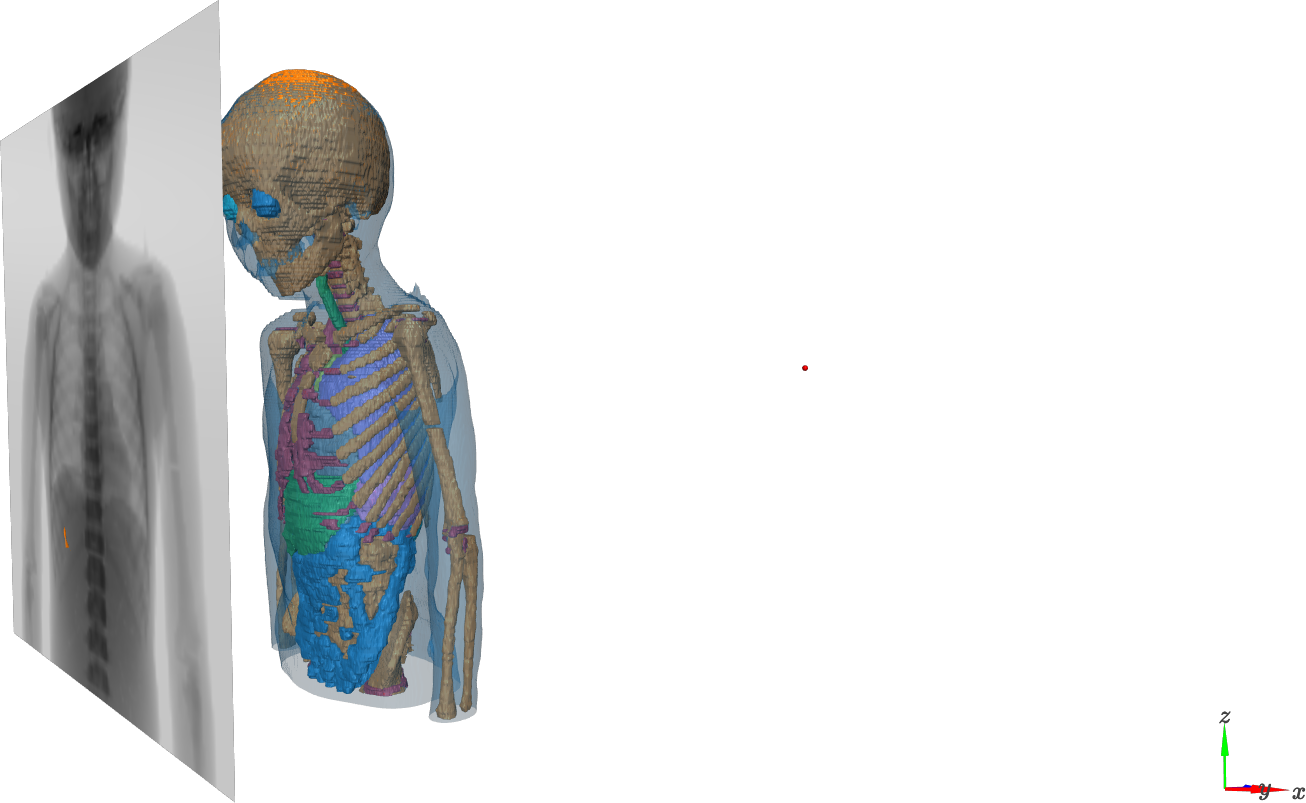

In [22]:
fname = root_path + "/visualisation.png"

if not os.path.exists(fname):

    plot = visualise(use_log=True)
    plot.grid_visible = False

    plot.display()
else:
    display(Image(fname, width=800))

In [23]:
if not os.path.exists(fname):
    if plot is not None:

        plot.fetch_screenshot()

        data = base64.b64decode(plot.screenshot)
        with open(fname,'wb') as fp:
            fp.write(data)

## Add Poisson noise
<!--
1. Load the raw projection in the RAM
2. Convert the image in keV or MeV into number of photons
3. Add the Poisson noise
4. Convert the image in number of photons into keV or MeV
5. Apply the flat-field correction -->

In [24]:
gvxr.enablePoissonNoise()

def getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel):
    gvxr.setNumberOfPhotons(target_number_of_photons_per_pixel)
    return np.array(gvxr.computeXRayImage(), dtype=np.single)

In [25]:
fig_plot = None
def chooseNumberOfPhotonsPerPixel(xray_image: np.array, number_of_photons_per_pixel:int=15000, figsize=(10, 5)):

    """
    Use Matplotlib and a Jupyter widget to display the X-ray image with Poisson noise.
    The number of photons per pixel can be change interactively.

    @param xray_image: The image to display
    @number_of_photons_per_pixel: the number of photons per pixel (default: 15000)
    @gamma figsize: the size of the figure (default: (10, 5))
    """

    global target_number_of_photons_per_pixel, fig_plot
    target_number_of_photons_per_pixel = number_of_photons_per_pixel

    noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)

    fig_plot = plt.figure(figsize=figsize)
    ax_img = plt.subplot(111)
    img = plt.imshow(noisy_image, cmap="gray")
    # cbar = fig_plot.colorbar(img, orientation='vertical')
    title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
    ax_img.set_title(title_str)
    plt.tight_layout()
    plt.margins(0,0)

    plt.close()

    ## Callback function: plot y=Acos(x+phi)
    def update_plot(number_of_photons_per_pixel):
        global target_number_of_photons_per_pixel
        target_number_of_photons_per_pixel = number_of_photons_per_pixel
        noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)
        img = ax_img.imshow(noisy_image, cmap="gray")
        title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
        ax_img.set_title(title_str)
        # fig_plot.colorbar(img, cax=cbar.ax, orientation='vertical')

        display(fig_plot)

    interact(update_plot,
             number_of_photons_per_pixel=widgets.IntSlider(value=number_of_photons_per_pixel, min=10, max=50000, step=10, description="Photons/pixels"))

In [26]:
chooseNumberOfPhotonsPerPixel(projection_in_MeV, number_of_photons_per_pixel=15000, figsize=(10, 5))

interactive(children=(IntSlider(value=15000, description='Photons/pixels', max=50000, min=10, step=10), Output…

In [27]:
fig_plot.savefig(root_path + "/output/noisy-projection.png", dpi=72)

In [28]:
print("Photons per pixels:", target_number_of_photons_per_pixel)

Photons per pixels: 15000


## Flat images

Create the flat field image

In [29]:
white_slider = widgets.IntSlider(value=25, min=1, max=100, step=1, description='Number of flat images:')
white_slider

IntSlider(value=25, description='Number of flat images:', min=1)

In [30]:
print("Number of flat images:", white_slider.value)
json2gvxr.params["Scan"]["NumberOfWhiteImages"] = white_slider.value

Number of flat images: 25


In [31]:
fname = root_path + "/output/flat.tif"

flats = []

for i in range(white_slider.value):
    flats.append(gvxr.getWhiteImage())

flat_field = np.average(flats, axis=0)

imwrite(fname, flat_field.astype(np.single), compression='zlib')

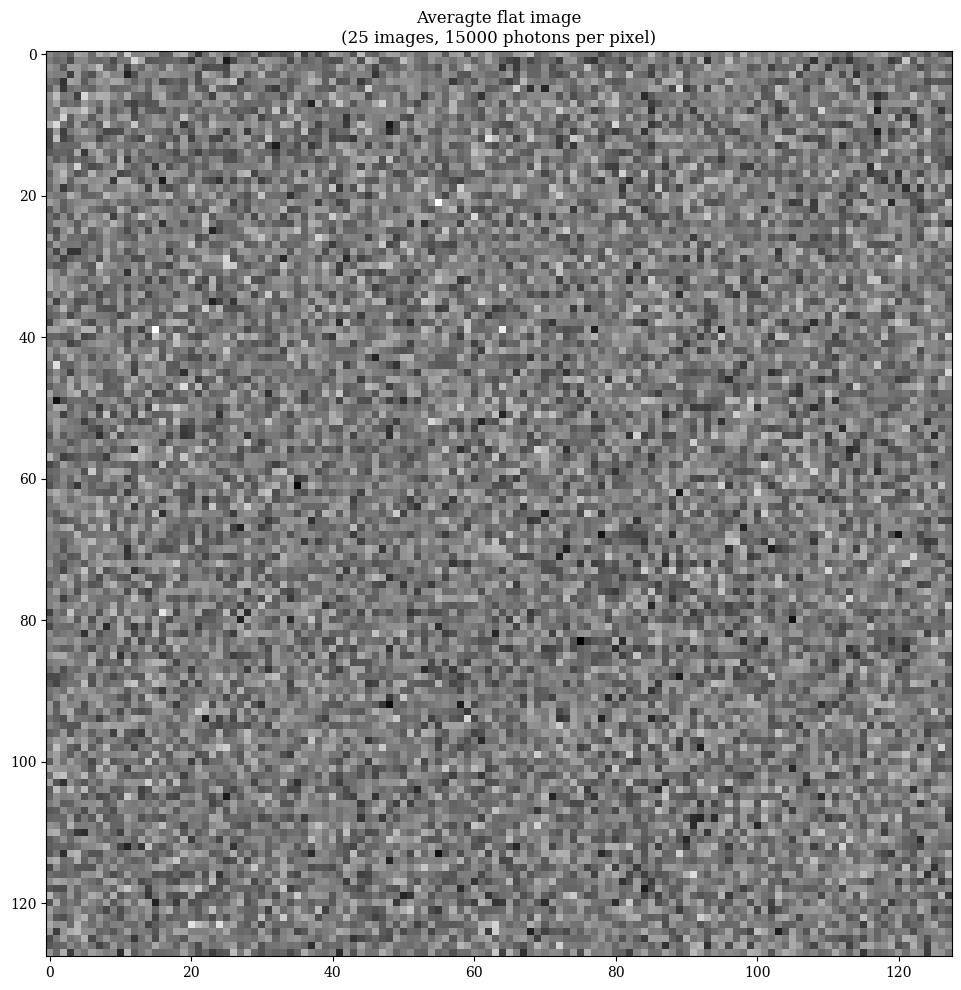

In [32]:
total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()


fig = plt.figure(figsize = (10, 10))
plt.title("Averagte flat image\n(" + str(white_slider.value) + " images, " + str(target_number_of_photons_per_pixel) + " photons per pixel)")
img = plt.imshow(flat_field, cmap='gray')
plt.tight_layout()
plt.savefig(root_path + "/output/average-flat-field.png", dpi=72)

## Perfom the CT scan

In [33]:
angles = json2gvxr.initScan()

Set up the CT Scan


In [34]:
number_of_angles = json2gvxr.params["Scan"]["NumberOfProjections"]
angles = json2gvxr.doCTScan()

In [35]:
if json2gvxr.white_image is not None:
    white_image = json2gvxr.white_image
    fname = root_path + "/output/flat.tif"
    imwrite(fname, flat_field.astype(np.single), compression='zlib')

In [36]:
print("First angle:", angles[0])
print("Last angle:", angles[-1])
print("Number of angles:", number_of_angles)

First angle: 0.0
Last angle: 358.0110497237569
Number of angles: 181


## CT reconstruction

In [37]:
reader = JSON2gVXRDataReader(file_name=json_fname)
data = reader.read()
reconstruction = reconstruct(data, "CONEBEAM", False, verbose=1)

[128, 128]
[3.90625, 3.90625]
Source shape: CONEBEAM
Use CIL
data.geometry 3D Cone-beam tomography
System configuration:
	Source position: [    0., -1000.,     0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [ 0.,  0., -1.]
	Detector position: [  0., 150.,   0.]
	Detector direction x: [-1.,  0.,  0.]
	Detector direction y: [ 0.,  0., -1.]
Panel configuration:
	Number of pixels: [128 128]
	Pixel size: [3.90625 3.90625]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 181
	Angles 0-20 in degrees:
[ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26., 28.,
 30., 32., 34., 36., 38.]
Distances in units: units distance
Cone beam detected
Backend: Tigre
Use plugin directly:  False
FDK recon

Input Data:
	angle: 181
	vertical: 128
	horizontal: 128

Reconstruction Volume:
	vertical: 128
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter 

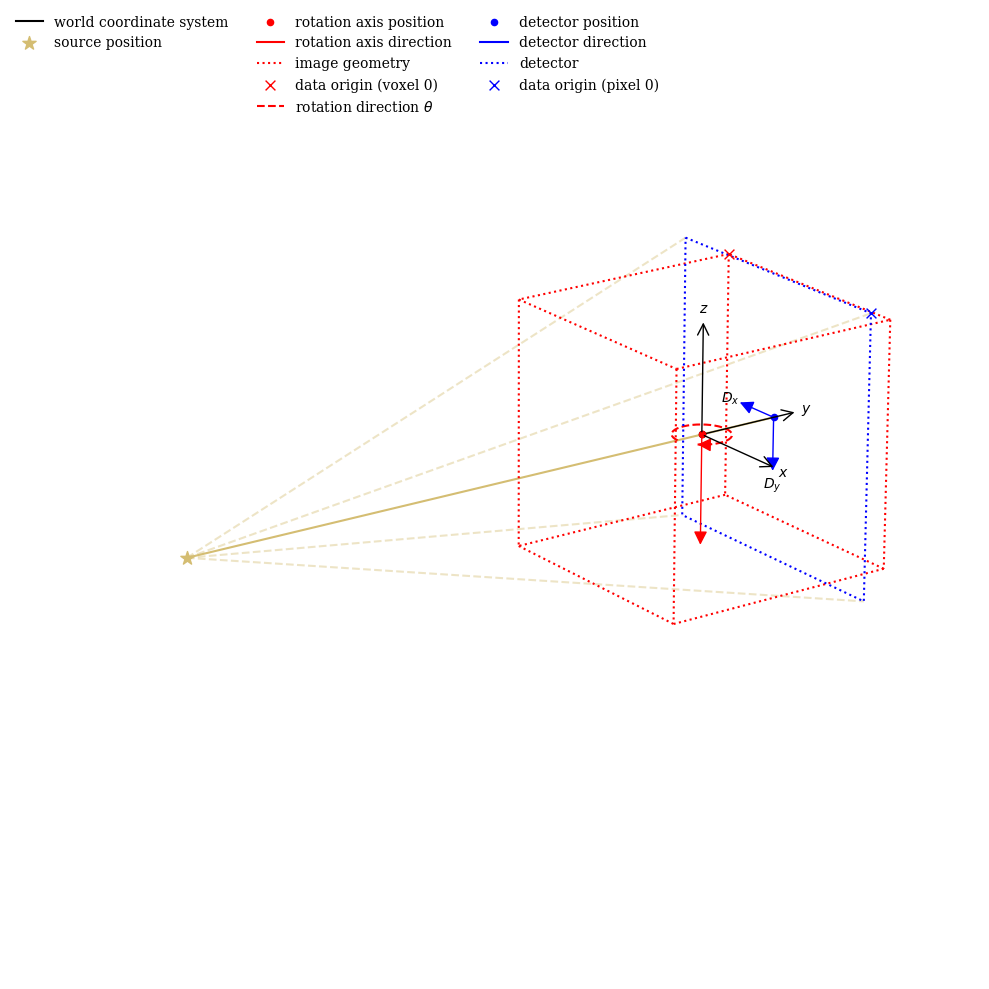

Unable to save image


<Figure size 640x480 with 0 Axes>

In [38]:
if has_cil:
    fig = show_geometry(data.geometry)
    fig.save(root_path  + "/Noise-CBCT/CT-geometry.png", dpi=72)

In [39]:
islicer(reconstruction, direction='vertical')

In [40]:
islicer(reconstruction, direction='horizontal_x')

In [41]:
fname = root_path  + "/output/CT_in_mu.mha"

In [42]:
reconstruction_as_array = reconstruction.as_array()

In [43]:
detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
spacing = detector_size / number_of_pixels

print("CT volume saved in", fname)
sitk_image = sitk.GetImageFromArray(reconstruction_as_array)
sitk_image.SetSpacing([spacing[0], spacing[0], spacing[1]])
sitk.WriteImage(sitk_image, fname, useCompression=True)

CT volume saved in /home/fpvidal/PROGRAMMING/GitHub/CIL-User-Showcase/gVXR2CIL/output/CT_in_mu.mha


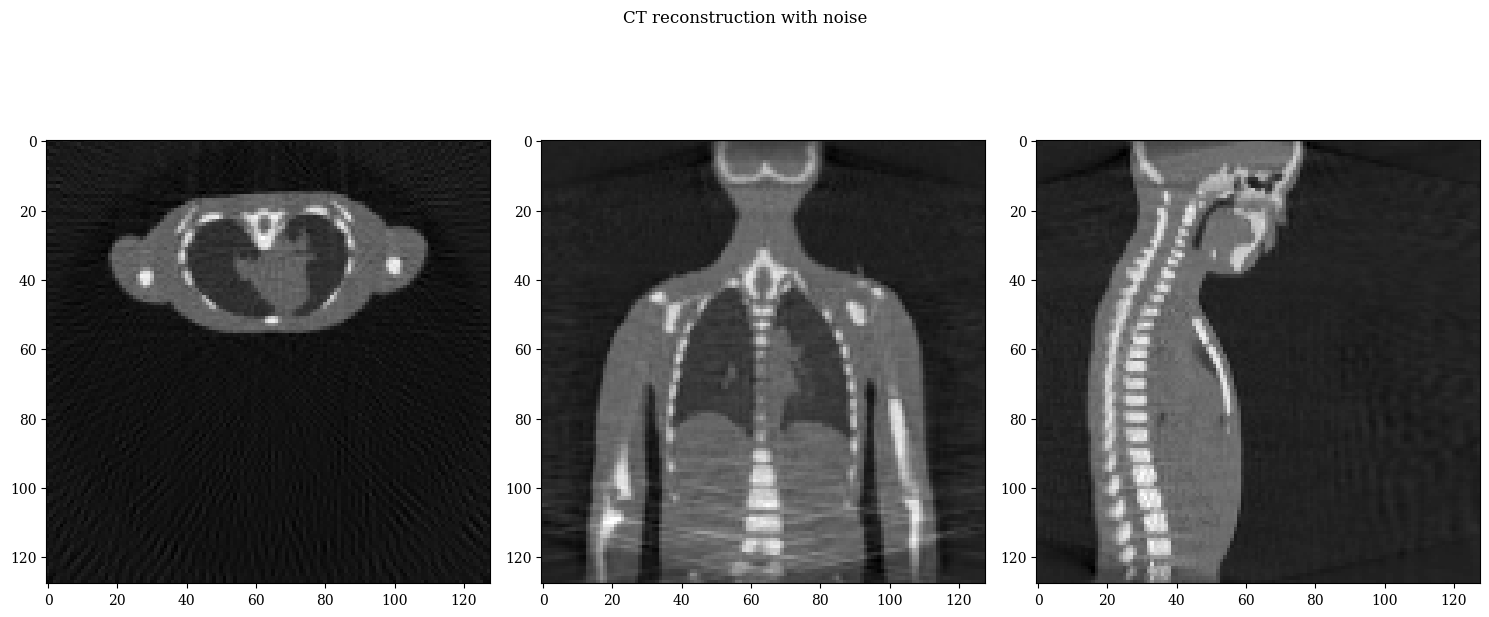

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7))
plt.suptitle("CT reconstruction with noise")
ax1.imshow(reconstruction_as_array[ int(reconstruction_as_array.shape[0] * 0.5), :, :], cmap='gray')
ax2.imshow(reconstruction_as_array[ :, int(reconstruction_as_array.shape[1] * 0.25), :], cmap='gray')
ax3.imshow(reconstruction_as_array[ :, :, int(reconstruction_as_array.shape[2] * 0.5)], cmap='gray')
plt.tight_layout()
plt.savefig(root_path  + "/output/plotCT.png", dpi=72)
plt.show()

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [45]:
gvxr.terminate()

Mon Nov  6 16:35:08 2023 ---- Destroy all the windows
Mon Nov  6 16:35:08 2023 ---- Destroy window 0(0x559f103d90a0)
